In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.interpolate import UnivariateSpline
from collections import namedtuple

plt.style.use(['science', 'no-latex', 'grid', 'russian-font'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.markersize'] = 2.5

Values = namedtuple('Values', 'label values')

def plot(data: dict, x_name: str, y_name: str, fmt='.', x_min=None, x_max=None, y_min=None, y_max=None):
    fig = plt.figure()
    ax = plt.axes()
    for name, data in data.items():
        x_data = data[x_name].values
        y_data = data[y_name].values
        if len(x_data) != len(y_data):
            raise ValueError("x and y data must have the same length")
        idx = np.ones(len(x_data), dtype=bool)
        if x_min is not None:
            idx &= (x_data >= x_min)
        if x_max is not None:
            idx &= (x_data <= x_max)
        if y_min is not None:
            idx &= (y_data >= y_min)
        if y_max is not None:
            idx &= (y_data <= y_max)
        ax.plot(x_data[idx], y_data[idx], fmt, label=name)
    ax.set_xlabel(data[x_name].label)
    ax.set_ylabel(data[y_name].label)
    ax.set_title(f'{y_name} on {x_name}')
    plt.legend()
    fname = f'{y_name}_on_{x_name}'
    directory = 'out'
    if x_min is not None:
        fname += f'_xmin_{x_min}'
    if x_max is not None:
        fname += f'_xmax_{x_max}'
    if y_min is not None:
        fname += f'_ymin_{y_min}'
    if y_max is not None:
        fname += f'_ymax_{y_max}'

    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(f'{directory}/{fname}.png')

    plt.show()

In [28]:

files = ['1_down.csv', '2_down.csv'] # , '3_down.csv'
L = {'1_down.csv': 31e-3, '2_down.csv': 27.6e-3}
all_data = {}
for file in files:
    raw_data = np.genfromtxt(f'../../data/2025-02/{file}', delimiter='\t', names=True)[1:]

    I = raw_data['RIGOLcurrent']
    U = raw_data['KEYSIGHTvoltage']
    L0 = L[file]
    Unorm = U / L0
    
    R = U / I
    T0 = 293.15
    R0 = np.mean(R[-8:-2])
    Tfunc = lambda RdivR0: T0 * RdivR0 ** (1/1.227)
    T = Tfunc(R/R0)

    sort_idx = np.argsort(I)
    I_sorted = I[sort_idx]
    T_sorted = T[sort_idx]
    T_spline = UnivariateSpline(I_sorted, T_sorted, s=3000)
    I_fine = np.linspace(I_sorted.min(), I_sorted.max(), 1000)
    dT_dI = T_spline.derivative()(I_fine)

    all_data[file] = {
        'I': Values(label='Current (A)', values=I),
        'U_norm': Values(label='Normalized voltage (V/m)', values=Unorm),
        'T': Values(label='Temperature (K)', values=T),
        'dT_dI': Values(label='dT / dI', values=dT_dI),
        'I_fine': Values(label='Current (A)', values=I_fine)
    }

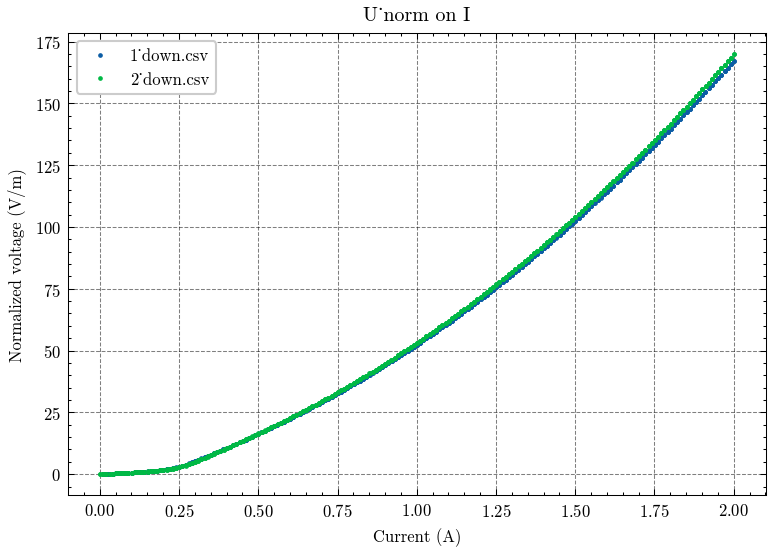

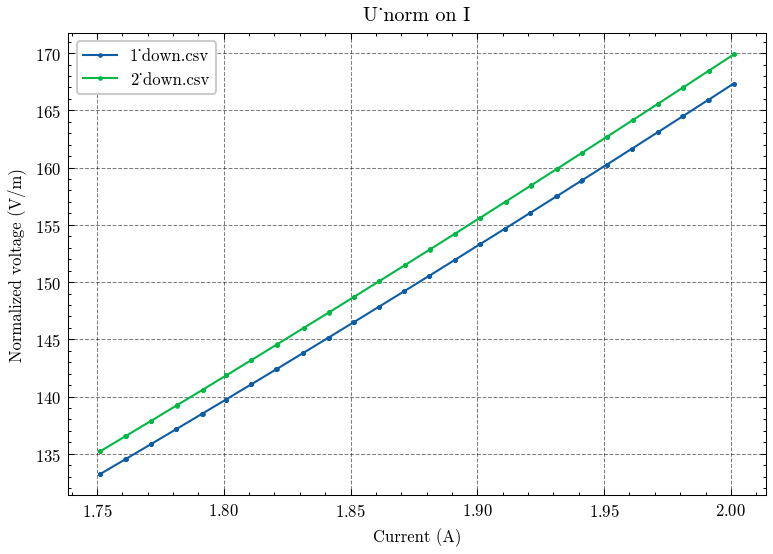

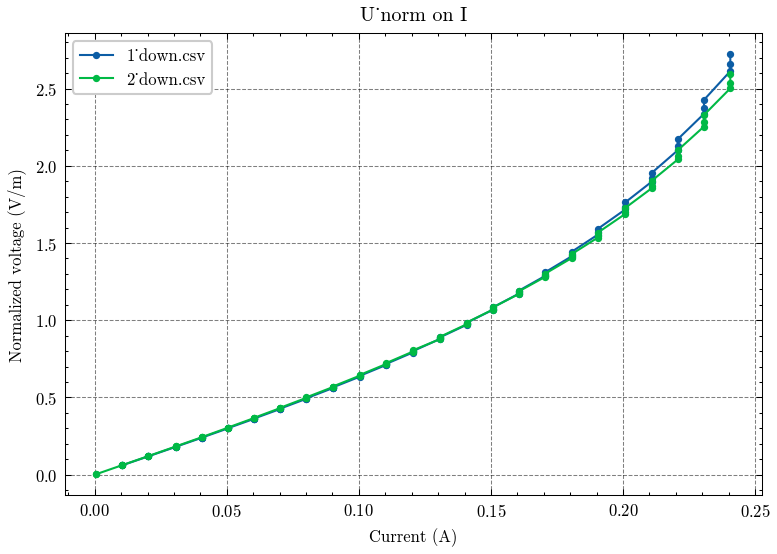

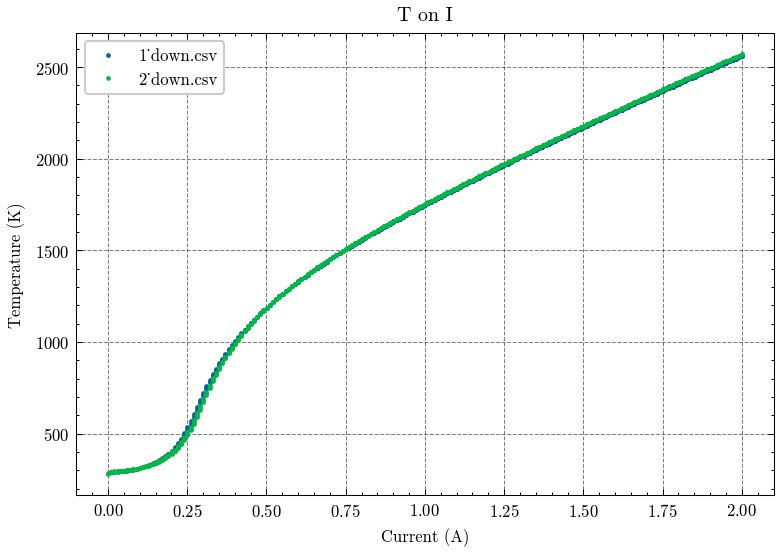

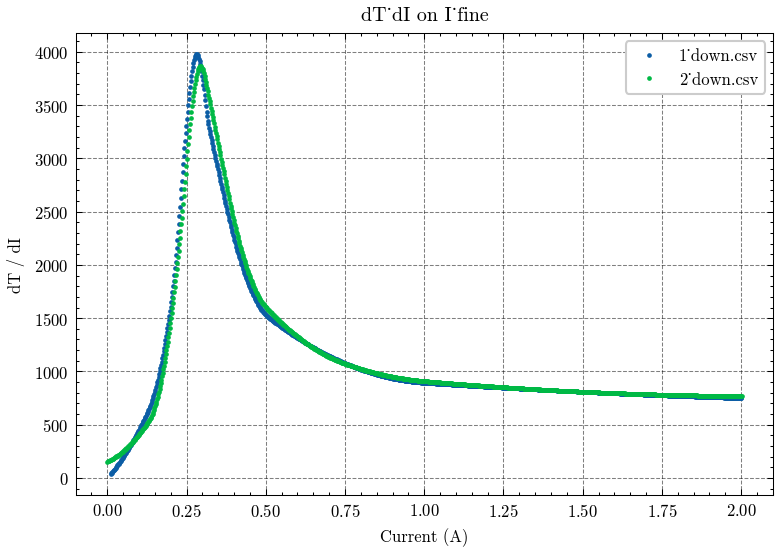

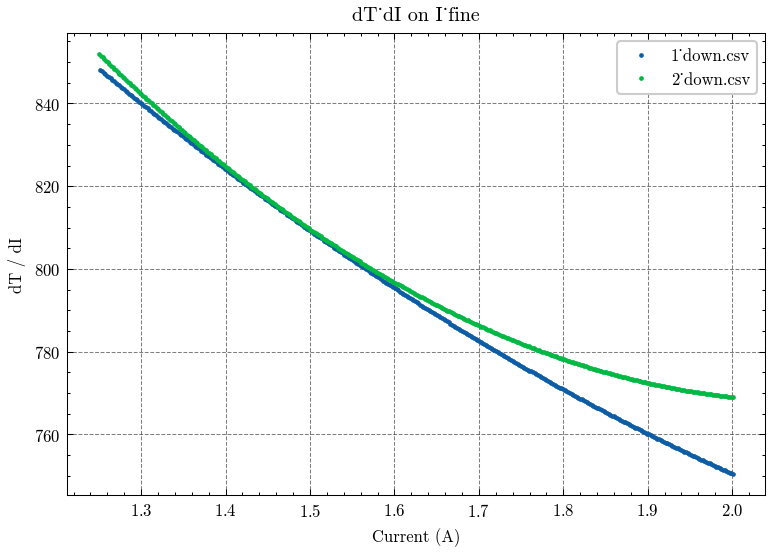

In [31]:
plot(all_data, 'I', 'U_norm')
plot(all_data, 'I', 'U_norm', fmt='.-', x_min=1.75)
plot(all_data, 'I', 'U_norm', fmt='o-', x_max=0.25)
plot(all_data, 'I', 'T')
plot(all_data, 'I_fine', 'dT_dI')
plot(all_data, 'I_fine', 'dT_dI', x_min=1.25)